# Pulsar Folding and Searching 

Pulsar searching is a very time and compute intensive task. Searching for repeating signals within noisy data is a difficult issue alone, plus the fact massive volume of data and you got yourself a very difficult problem. 

This notebook illustrates the fundemental algorithms that are used for searching and detecting regular pusles within radio spectrograms. 

First we start off with downloading the data and `BLIMPY` which is an I/O tool developed to interface with the radio data!

In [0]:
!pip install blimpy
!wget http://blpd13.ssl.berkeley.edu/borisov/AGBT19B_999_124/spliced_blc40414243444546o7o0515253545556o7o061626364656667_guppi_58837_86186_PSR_B0355+54_0013.gpuspec.8.0001.fil
!wget http://blpd13.ssl.berkeley.edu/dl/GBT_58402_64873_J1509+5531_time.h5
# http://ipta.phys.wvu.edu/files/student-week-2017/IPTA2017_KuoLiu_pulsartiming.pdf

# Loading Data

First we load the data. NOTE targets with the starting name of PSR are radio scans of known pulsars! On the other hand files starting with HIP are catelogued stars that shouldn't have pulsar characteristics. If you wish to learn more about the data checkout https://ui.adsabs.harvard.edu/abs/2019PASP..131l4505L/abstract

The header information gives vital info regarding the observational setup for the telescope. For example, the sensitivity of time or frequency or the range of frequency

In [18]:
from blimpy import Waterfall
import pylab as plt
import numpy as np
import math
from scipy import stats, interpolate
%matplotlib inline


header = Waterfall('/content/spliced_blc40414243444546o7o0515253545556o7o061626364656667_guppi_58837_86186_PSR_B0355+54_0013.gpuspec.8.0001.fil',load_data=True)
header.info()

obs = Waterfall('/content/spliced_blc40414243444546o7o0515253545556o7o061626364656667_guppi_58837_86186_PSR_B0355+54_0013.gpuspec.8.0001.fil', 
               t_start=0,t_stop= 60000,max_load=10)
# Loads data into numpy array 
data = obs.data
data.shape

blimpy.io.base_reader WARNING  Selection size of 8.17 GB, exceeding our size limit 1.00 GB. Instance created, header loaded, but data not loaded, please try another (t,v) selection.

--- File Info ---
     rawdatafile :                                 
     source_name :                     PSR_B0355+54
      machine_id :                               10
    telescope_id :                                6
         src_raj :                      3:58:53.496
         src_dej :                      54:13:14.88
        az_start :                              0.0
        za_start :                              0.0
       data_type :                                1
            fch1 :            11251.28173828125 MHz
            foff :                -0.3662109375 MHz
          nchans :                            10240
          nbeams :                                0
           ibeam :                                0
           nbits :                                8
   tstart (ISOT) : 

(60000, 1, 10240)

extracting integration 0...


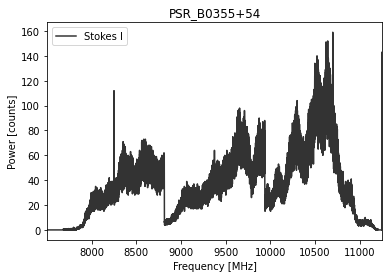

In [19]:
# Here we plot the integrated signal over time.
obs.plot_spectrum()

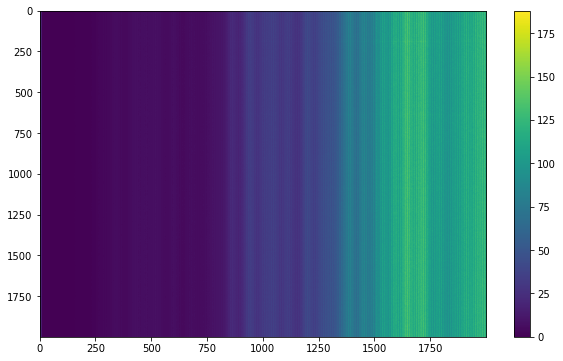

In [20]:
fig = plt.figure(figsize=(10, 6))
plt.imshow(data[:2000,0,:2000], aspect='auto')
plt.colorbar()

# Band Pass Removal
To remove the bandpass, we use spline lines to fit each channel to obtain a model of the bandpass of that channel. By using splines, we are able to fit the bandpass without fitting the more significant signals. 

If you want more details on this checkout https://github.com/FX196/SETI-Energy-Detection for more detailed explantion  

In [21]:
average_power = np.zeros((data.shape[2]))
shifted_power = np.zeros((int(data.shape[2]/8)))
x=[]
print("Fitting Spline")
for i in range(0,data.shape[2],8):
  if i%2500==0:
    print("Freq array index:"+ str(i))
  shifted_power[int(i/8)] = data[:,0,i].mean(axis=0)
  x.append(i)

tck = interpolate.splrep(x, shifted_power, s=0)
xnew = np.arange(0, 10232,1)
ynew = interpolate.splev(xnew, tck, der=0)

print("Finding the average intensitiy over time per frequency")
for i in range(data.shape[2]):
  if i%2500==0:
    print("Freq array index:"+ str(i))
  average_power[i]= data[:,0,i].mean(axis=0)

Fitting Spline
Freq array index:0
Freq array index:5000
Freq array index:10000
Finding the average intensitiy over time per frequency
Freq array index:0
Freq array index:2500
Freq array index:5000
Freq array index:7500
Freq array index:10000


Text(0, 0.5, 'Power')

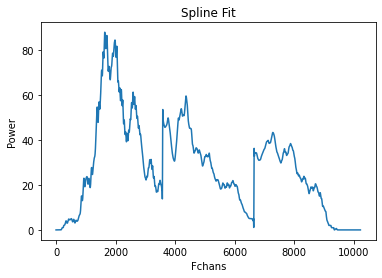

In [22]:
plt.figure()
plt.plot(xnew, ynew)
plt.title('Spline Fit')
plt.xlabel("Fchans")
plt.ylabel("Power")

Text(0, 0.5, 'Power')

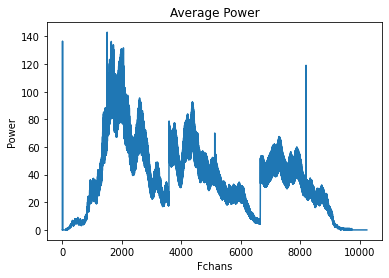

In [23]:
plt.figure()
plt.plot(average_power)
plt.title('Average Power')
plt.xlabel("Fchans")
plt.ylabel("Power")

Correcting Spline Fit
Freq array index:0
Freq array index:2500
Freq array index:5000
Freq array index:7500
Freq array index:10000


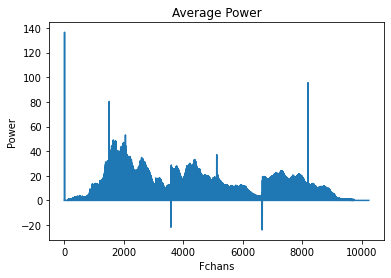

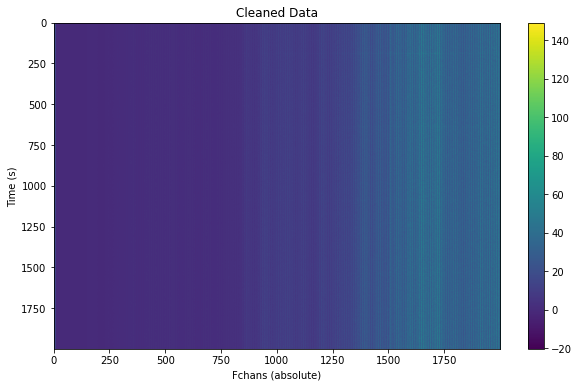

In [25]:
# We now subtract the spline from the original data. 
print("Correcting Spline Fit")
prepros = np.zeros(data.shape)
for i in range(data.shape[2]-8):
  if i%2500==0:
    print("Freq array index:"+ str(i))
  prepros[:,0,i]  = data[:,0,i] - ynew[i]


plt.figure()
plt.plot(prepros[:,0,:] .mean(axis = 0))
plt.title('Average Power')
plt.xlabel("Fchans")
plt.ylabel("Power")

fig = plt.figure(figsize=(10, 6))
plt.imshow(prepros[:2000,0,:2000], aspect='auto')
plt.title('Cleaned Data')
plt.xlabel("Fchans (absolute)")
plt.ylabel("Time (s)")
plt.colorbar()


# Detecting Pulses - Fourier Transforms and Folding

What we do next is we take the fast fourier transform of the original signal and take the magnitude of the fourier transform. A large magnitude indicates a potential period within that signal. AKA a repeating signal! 

If the magnitude of the fourier transform is above a certain threshold we can consider it as a candidate. 


In [0]:
# Functions to determine SNR and TOP candidates
def SNR(arr):
  index = np.argmax(arr)
  average_noise = arr.mean(axis=0)
  return math.log(arr[index]/average_noise) 

def top(arr, top = 10):
  candidate = []
  # Delete the first and second element fourier transform
  arr[0]=0
  arr[1]=0
  for i in range(top):
    index = np.argmax(arr)
    candidate.append(index)
    arr[index]=0
  return candidate
    

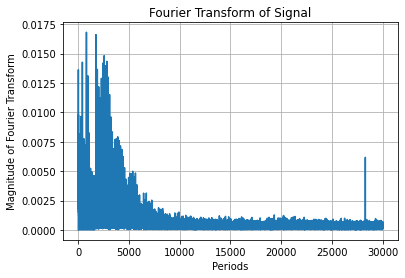

Signal To Noise Ratio for the Fourier Transform is: 3.3377138865513154
Most likely Candidates are: [134, 268, 402, 536, 1073, 1207, 805, 939, 1341, 670, 1475, 671, 1609, 3, 537]


In [53]:
#  Preforming the fourier transform.
%matplotlib inline
import scipy.fftpack
from scipy.fft import fft
N = 60000
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = prepros[:,0,:].mean(axis=1)
yf = fft(y)

xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

# Magintude of the fourier transform
# Between 0.00035 and 3.5 seconds
mag = np.abs(yf[:30000])
candidates = top(mag, top=15)
plt.plot(2.0/N * mag[1:])
plt.grid()
plt.title('Fourier Transform of Signal')
plt.xlabel("Periods")
plt.ylabel("Magnitude of Fourier Transform")
plt.show()

print("Signal To Noise Ratio for the Fourier Transform is: "+str(SNR(mag)))
print("Most likely Candidates are: "+str(candidates))


# Folding Algorithm 

The idea of the folding algorithm is to see if the signal forms a consistent profile as you fold / integrate the values together. If the profile appears consistent/stable then you're looking at an accurate reading of the pulsar's period! It is used to confirm the implications drawn from the fourier transform. It also forms a "finger print" of the pulsar!

![alt text](https://github.com/PetchMa/Pulsar_Folding/blob/master/assets/can_3.gif?raw=true)

1.6648318305384018


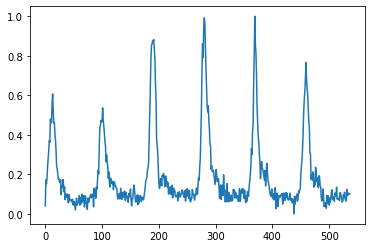

In [55]:
#  Lets take an example of such a period!
period = 537
fold = np.zeros((period, data.shape[2]))
multiples = int(data.data.shape[0]/period)
results = np.zeros((period))

for i in range(multiples-1):
  fold[:,:]=data[i*period:(i+1)*period,0,:]+ fold

results = fold.mean(axis=1)
results = results - results.min()
results = results / results.max()

print(SNR(results))

plt.plot(results)


The Signal To Noise of the Fold is: 1.6648318305384018


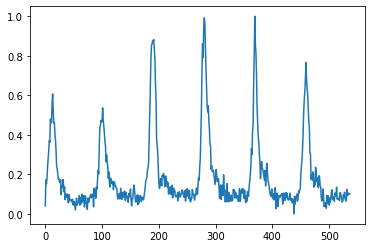

In [56]:
from scipy import stats 
data= prepros
period = 537
fold = np.zeros((period, data.shape[2]))
multiples = int(data.data.shape[0]/period)
results = np.zeros((period))

for i in range(multiples-1):
  fold[:,:]=data[i*period:(i+1)*period,0,:]+ fold
  results = fold.mean(axis=1)
  results = results - results.min()
  results = results / results.max()
  #  Generates multiple frames of the graph as it folds! 
  plt.plot(results)
  plt.title('Folded Signal Period '+str(period*0.000349)+" seconds| Fold Iteration: "+str(i))
  plt.xlabel("Time (Multiples of 0.00035s)")
  plt.ylabel("Normalized Integrated Signal")
  plt.savefig('/content/drive/My Drive/Deeplearning/Pulsars/output/candidates/CAN_3/multi_chan_'+str(period)+'_'+str(i)+'.png')
  plt.close()
  
results = fold.mean(axis=1)
results = results - results.min()
results = results / results.max()

print("The Signal To Noise of the Fold is: "+str(SNR(results)))
plt.plot(results)

# What Happens If The Data Doesn't Contain Pulses?

Below we will prove to you that this algorithm detects repeated pulses and excludes targets that do not include this feature! We will do so by loading a target that isn't known to contain pulsars.

Below we will rush through and apply the EXACT same algorithm but on a target that isn't a pulsar. 

blimpy.io.base_reader WARNING  Selection size of 1.97 GB, exceeding our size limit 1.00 GB. Instance created, header loaded, but data not loaded, please try another (t,v) selection.

--- File Info ---
DIMENSION_LABELS : [b'frequency' b'feed_id' b'time']
        az_start :                              0.0
       data_type :                                1
            fch1 :                2720.80078125 MHz
            foff :                -0.3662109375 MHz
           ibeam :                                0
      machine_id :                               10
          nbeams :                                0
           nbits :                                8
          nchans :                             2464
            nifs :                                1
     rawdatafile :                                 
     source_name :                   PSR_J1509+5531
         src_dej :                     55:31:31.994
         src_raj :                      15:09:25.58
    telescope_id :

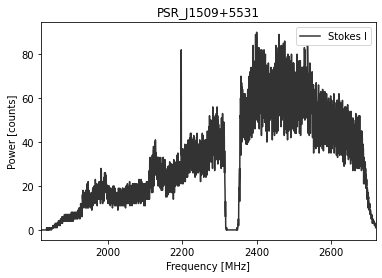

In [66]:
from blimpy import Waterfall
import pylab as plt
import numpy as np
import math
from scipy import stats, interpolate
%matplotlib inline


header = Waterfall('/content/GBT_58402_64873_J1509+5531_time.h5',load_data=True)
header.info()

obs = Waterfall('/content/GBT_58402_64873_J1509+5531_time.h5', 
               t_start=0,t_stop= 60000,max_load=10)
# Loads data into numpy array 
data = obs.data
data.shape
obs.plot_spectrum()

In [67]:
average_power = np.zeros((data.shape[2]))
shifted_power = np.zeros((int(data.shape[2]/8)))
x=[]
print("Fitting Spline")
for i in range(0,data.shape[2],8):
  if i%2500==0:
    print("Freq array index:"+ str(i))
  shifted_power[int(i/8)] = data[:,0,i].mean(axis=0)
  x.append(i)

tck = interpolate.splrep(x, shifted_power, s=0)
xnew = np.arange(0, 10232,1)
ynew = interpolate.splev(xnew, tck, der=0)

print("Finding the average intensitiy over time per frequency")
for i in range(data.shape[2]):
  if i%2500==0:
    print("Freq array index:"+ str(i))
  average_power[i]= data[:,0,i].mean(axis=0)

Fitting Spline
Freq array index:0
Finding the average intensitiy over time per frequency
Freq array index:0


Correcting Spline Fit
Freq array index:0


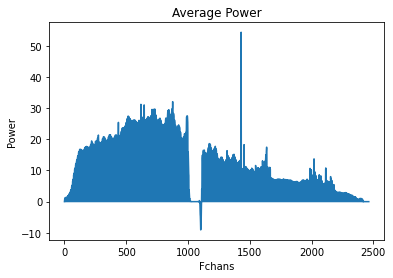

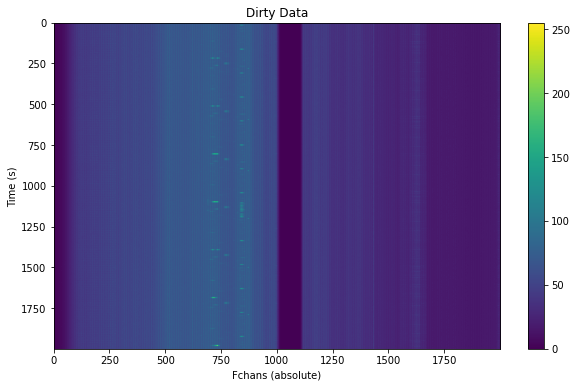

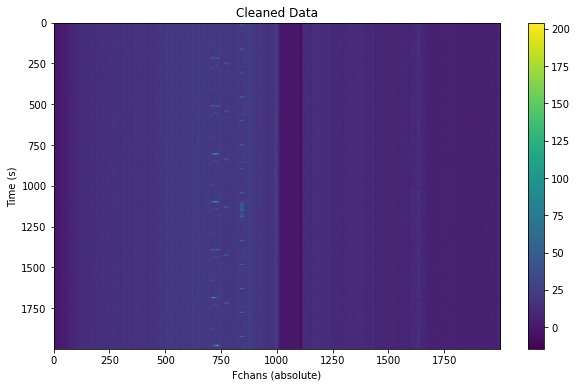

In [70]:
# We now subtract the spline from the original data. 
print("Correcting Spline Fit")
prepros = np.zeros(data.shape)
for i in range(data.shape[2]-8):
  if i%2500==0:
    print("Freq array index:"+ str(i))
  prepros[:,0,i]  = data[:,0,i] - ynew[i]


plt.figure()
plt.plot(prepros[:,0,:] .mean(axis = 0))
plt.title('Average Power')
plt.xlabel("Fchans")
plt.ylabel("Power")



fig = plt.figure(figsize=(10, 6))
plt.imshow(data[:2000,0,:2000], aspect='auto')
plt.title('Dirty Data')
plt.xlabel("Fchans (absolute)")
plt.ylabel("Time (s)")
plt.colorbar()

fig = plt.figure(figsize=(10, 6))
plt.imshow(prepros[:2000,0,:2000], aspect='auto')
plt.title('Cleaned Data')
plt.xlabel("Fchans (absolute)")
plt.ylabel("Time (s)")
plt.colorbar()

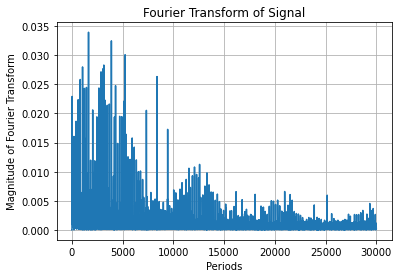

Signal To Noise Ratio for the Fourier Transform is: 3.6805870160763265
Most likely Candidates are: [4194, 205, 2253, 1639, 2, 8389, 2048, 1229, 3, 1843, 1024, 4096, 4195, 1434, 2867]


In [71]:
#  Preforming the fourier transform.
%matplotlib inline
import scipy.fftpack
from scipy.fft import fft
N = 60000
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = prepros[:,0,:].mean(axis=1)
yf = fft(y)

xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

# Magintude of the fourier transform
# Between 0.00035 and 3.5 seconds
mag = np.abs(yf[:30000])
candidates = top(mag, top=15)
plt.plot(2.0/N * mag[1:])
plt.grid()
plt.title('Fourier Transform of Signal')
plt.xlabel("Periods")
plt.ylabel("Magnitude of Fourier Transform")
plt.show()

print("Signal To Noise Ratio for the Fourier Transform is: "+str(SNR(mag)))
print("Most likely Candidates are: "+str(candidates))


# NOTICE
Notice how the signal to noise ratio is a lot smaller. Typically with a SNR of less than 9, the likelyhood of a pulsar is very very low. 